In [1]:
# imports
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, InputLayer, SimpleRNN, LSTM, Reshape , BatchNormalization, Dropout 
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [2]:
# load the dataset
# connectium
# original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_connectium.csv")
# another enterprise
original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_sip.csv")

# show the original data
original_dataset.head()

,Task_ID,Priority,Project_ID,Project_code,Category,Total_developers,TaskPerformance,DeveloperPerformance,Hours_estimate,Hours_logged,Difference
0,7963,4,9,PC9,Release,1,-8.95,-5.95,3.0,11.95,8.95
1,7963,4,9,PC9,Release,1,-8.95,NaN,3.0,11.95,8.95
2,12609,1,6,PC6,Enhancement,1,-8.94,-8.94,35.0,43.94,8.94
3,13397,1,5,PC5,Testing,1,-8.92,-8.92,14.0,22.92,8.92
4,6063,1,9,PC9,Enhancement,1,8.82,NaN,35.0,26.18,8.82


In [3]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Task_ID               4267 non-null   int64  
 1   Priority              4267 non-null   int64  
 2   Project_ID            4267 non-null   int64  
 3   Project_code          4267 non-null   object 
 4   Category              4267 non-null   object 
 5   Total_developers      4267 non-null   int64  
 6   TaskPerformance       4267 non-null   float64
 7   DeveloperPerformance  3830 non-null   float64
 8   Hours_estimate        4267 non-null   float64
 9   Hours_logged          4267 non-null   float64
 10  Difference            4267 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 366.8+ KB


In [4]:
# drop all the unnecessary columns
clean_dataset = original_dataset[[
    'Task_ID',
    'Project_ID',
    'Priority',
    'Category',
    'Total_developers',
    'Hours_estimate',
    'Hours_logged',
]]

# desnormalizing data
clean_dataset = pd.get_dummies(clean_dataset, columns=['Category'])
clean_dataset = clean_dataset.astype(int)

# check if is necessary to drop any row with NaN/empty/null values

In [5]:
clean_dataset.head()

,Task_ID,Project_ID,Priority,Total_developers,Hours_estimate,Hours_logged,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
0,7963,9,4,1,3,11,0,0,1,0
1,7963,9,4,1,3,11,0,0,1,0
2,12609,6,1,1,35,43,0,1,0,0
3,13397,5,1,1,14,22,0,0,0,1
4,6063,9,1,1,35,26,0,1,0,0


In [6]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Task_ID               4267 non-null   int32
 1   Project_ID            4267 non-null   int32
 2   Priority              4267 non-null   int32
 3   Total_developers      4267 non-null   int32
 4   Hours_estimate        4267 non-null   int32
 5   Hours_logged          4267 non-null   int32
 6   Category_Bug          4267 non-null   int32
 7   Category_Enhancement  4267 non-null   int32
 8   Category_Release      4267 non-null   int32
 9   Category_Testing      4267 non-null   int32
dtypes: int32(10)
memory usage: 166.8 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [7]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.4)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (2560, 10)
    Test: (854, 10)
    Validation: (853, 10)


### Data analysis

Calculate the correlation and other statistics on the train dataset

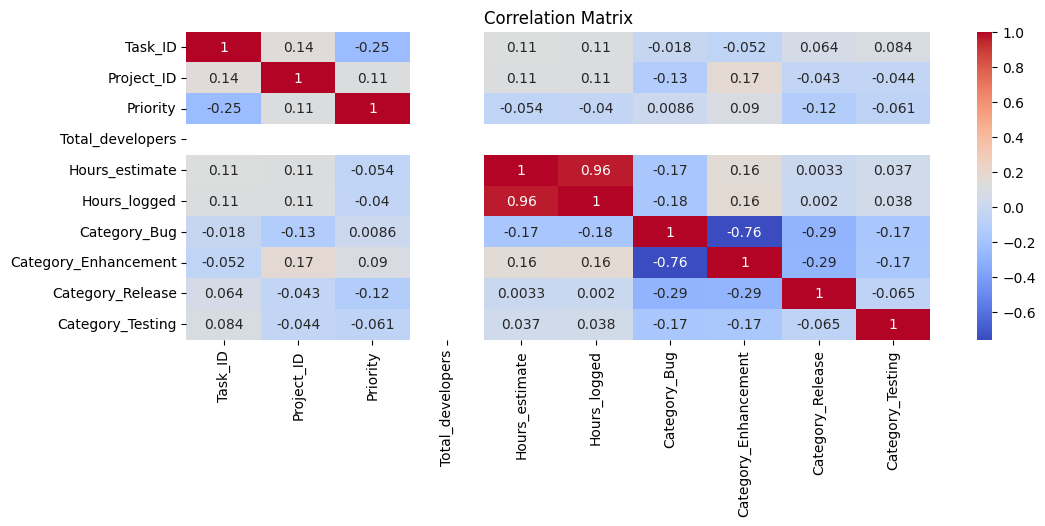

In [8]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Hours_logged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# another interesting statistics 
train_stats = train_dataset.describe()
train_stats.pop("Hours_logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Task_ID,2560.0,7233.912891,2866.164587,2283.0,4935.75,7044.5,9059.25,14355.0
Project_ID,2560.0,5.076953,4.271091,2.0,2.00,2.0,9.00,18.0
Priority,2560.0,2.242969,1.726387,1.0,1.00,1.0,3.00,10.0
Total_developers,2560.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
Hours_estimate,2560.0,4.673047,8.998922,0.0,1.00,2.0,7.00,260.0
Category_Bug,2560.0,0.434375,0.495771,0.0,0.00,0.0,1.00,1.0
Category_Enhancement,2560.0,0.430469,0.495239,0.0,0.00,0.0,1.00,1.0
Category_Release,2560.0,0.100391,0.300579,0.0,0.00,0.0,0.00,1.0
Category_Testing,2560.0,0.034766,0.183221,0.0,0.00,0.0,0.00,1.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [10]:
train_label = train_dataset.pop('Hours_logged')
test_label = test_dataset.pop('Hours_logged')
validation_label = validation_dataset.pop('Hours_logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

# temporaly
# recover the original #Developer column
if normed_train_data['Total_developers'].isna().any():
    normed_train_data['Total_developers'] = normed_train_data['Total_developers'].fillna(1)
    normed_test_data['Total_developers'] = normed_test_data['Total_developers'].fillna(1)
    normed_validation_data['Total_developers'] = normed_validation_data['Total_developers'].fillna(1)

In [12]:
# show a part of the normalized data
normed_train_data.head()

,Task_ID,Project_ID,Priority,Total_developers,Hours_estimate,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
1037,0.172735,-0.720414,1.017751,1.0,0.258581,-0.876160,-0.869215,2.992923,-0.189747
1987,-1.118538,1.386776,-0.719983,1.0,-0.185916,-0.876160,-0.869215,-0.333991,5.268131
1500,1.049865,-0.252149,-0.719983,1.0,-0.297041,1.140899,-0.869215,-0.333991,-0.189747
1844,0.308805,-0.720414,-0.140738,1.0,-0.519290,1.140899,-0.869215,-0.333991,-0.189747
4100,0.945196,-0.252149,1.596995,1.0,-0.519290,-0.876160,1.150014,-0.333991,-0.189747


## Building the Neural Network Model

## Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [13]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [45]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(32, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(128, Activation('relu'), name='hidden_layer_3'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model

### Third Model

Five hidden layers, all with 64 neurons

Learning rate at 0.001

In [46]:
def build_third_model_five_hidden_layers():
    model = Sequential(name = "ThirdModelFiveHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(64, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_4'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_5'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model

### Fourth Model

Recurrent Neural Network

In [40]:
def build_fourth_model_LSTM_hidden_layers():
    model = Sequential(name = "FourthModelLSTMHiddenLayers")

    model.add(Reshape(
        (normed_train_data.shape[1], 1),
        input_shape=(normed_train_data.shape[1],)
    ))

    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
  
    model.add(Dense(1, Activation('linear')))

    learnig_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model    

### Fith Model

Support Vector Machine

Best params hash: {'kernel': 'linear'}
Accuracy:  0.8744658023545171
Best estimator:  SVR(kernel='linear')
Best index:  0
Best score:  0.9055576293410604
Scorer:  <sklearn.metrics._scorer._PassthroughScorer object at 0x00000170E8C8C850>
MSE: 7.2444411276601866


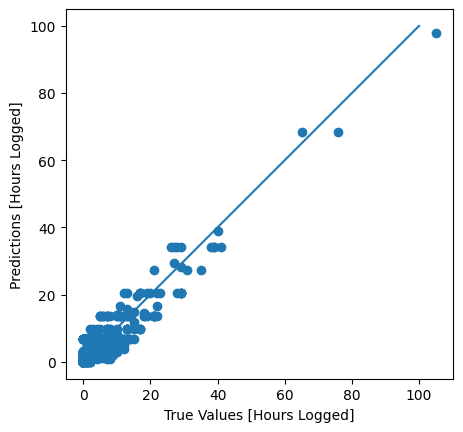

In [72]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf')}

svr = SVR()
LinearSVC = GridSearchCV(svr, parameters)
history = LinearSVC.fit(normed_train_data, train_label)

print("Best params hash: {}".format(LinearSVC.best_params_))
print("Accuracy: " , LinearSVC.score(normed_test_data, test_label))
print("Best estimator: " , LinearSVC.best_estimator_)
print("Best index: " , LinearSVC.best_index_)
print("Best score: " , LinearSVC.best_score_)
print("Scorer: " , LinearSVC.scorer_)


test_predictions = LinearSVC.predict(normed_test_data)
print("MSE:" , mean_squared_error(test_label, test_predictions))

axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
_ = plt.plot([0,100], [0,100])




### Choose the model

To choose the model uncomment the line of the one that you want yo fit

In [14]:
model = build_first_model_two_hidden_layers()
# model = build_second_model_three_hidden_layers()
# model = build_third_model_five_hidden_layers()
# model = build_fourth_model_LSTM_hidden_layers()

Test the model before training (this will use the initial weights) which in fact will generate random values. We will take the first 10 rows

In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 132ms/step


array([[-0.13306132],
       [ 0.08160743],
       [-0.05534647],
       [-0.0960554 ],
       [ 0.04117624],
       [-0.32734686],
       [-0.05739627],
       [-0.20191805],
       [-0.0115878 ],
       [-0.09182442]], dtype=float32)

Save checkpoints during training

In [16]:
# checkpoint_path = r".\checkpoint_logs\connectium\data.ckpt"
checkpoint_path = r".\checkpoint_logs\sip\data.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
                                                  )

## Model training

In [17]:
%%time

# for first model - is winning
epochs = 64
batch_size = 10

# for second model
# epochs = 600
# batch_size = 100
# for third model

print("Summary of the model")
model.summary()

history = model.fit(
    normed_train_data,
    train_label,
    batch_size=batch_size,  
    epochs=epochs, 
    verbose=0,
    shuffle=True,
    steps_per_epoch = int(normed_train_data.shape[0] / batch_size),
    validation_data=(normed_validation_data, validation_label),
    callbacks=[
        tfdocs.modeling.EpochDots(),
        ckpt_callback,
    ]
)

Summary of the model
Model: "FirstModelTwoHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 hidden_layer_1 (Dense)      (None, 50)                550       
                                                                 
 hidden_layer_2 (Dense)      (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3251 (12.70 KB)
Trainable params: 3251 (12.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Epoch: 0, accuracy:0.2113,  loss:43.1253,  mae:3.1681,  mse:43.1253,  val_accuracy:0.2521,  val_loss:7.9977,  val_m

Summary of the results after earch epoch

In [18]:
history_dataset = pd.DataFrame(history.history)
history_dataset['epoch'] = history.epoch
history_dataset.tail()

,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch
59,5.767026,0.305078,1.576470,5.767026,7.085843,0.317702,1.771344,7.085843,59
60,5.670581,0.302344,1.572610,5.670581,6.997344,0.315358,1.754050,6.997344,60
61,5.626346,0.299219,1.579072,5.626346,7.124060,0.310668,1.781459,7.124060,61
62,5.619432,0.296875,1.575210,5.619432,7.375635,0.310668,1.770212,7.375636,62
63,5.870738,0.302734,1.584724,5.870738,7.194653,0.304807,1.773147,7.194653,63


Saving error results

In [19]:
# hystory_dataset.to_csv(r".\outputs\history_connectium.csv")
history_dataset.to_csv(r"./outputs/history_sip.csv", index=False)

### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [20]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print("Predicted Hours Logged")
example_result

1/1 [==============================] - 0s 27ms/step
Predicted Hours Logged


array([[ 6.5478463 ],
       [ 2.9149776 ],
       [ 1.621837  ],
       [-0.13276541],
       [-0.14079821],
       [ 4.8630443 ],
       [ 1.11299   ],
       [16.36131   ],
       [ 1.2039192 ],
       [-0.15999463]], dtype=float32)

In [21]:
print("Real Hours Logged")
train_label[:10]

Real Hours Logged


1037    10
1987     2
1500     3
1844     1
4100     0
310      1
4012     1
179     14
3262     0
3862     0
Name: Hours_logged, dtype: int32

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

We will graph the error metrics across epochs and then see how the model evalutes itself

Text(0, 0.5, 'MAE [Hours Logged]')

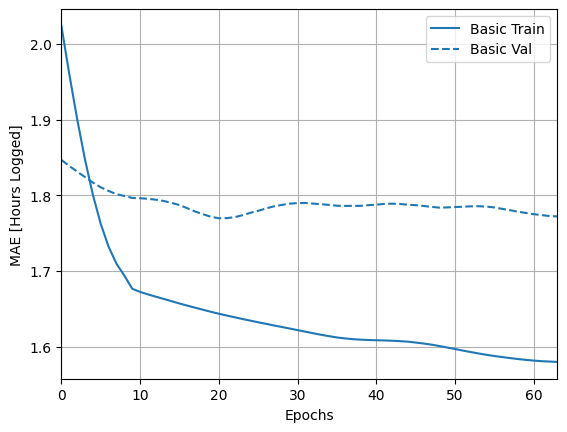

In [22]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Hours Logged]')

### Error rate on Train Sample

In [23]:
loss, accuracy, mae, mse = model.evaluate(normed_train_data, train_label, verbose=2)

print("Mean Abs Error: {:5.2f} Hours_logged".format(mae))
print("Mean Squared Error: {:5.2f} Hours_logged".format(mse))


80/80 - 0s - loss: 5.8069 - accuracy: 0.3086 - mae: 1.5608 - mse: 5.8069 - 145ms/epoch - 2ms/step
Mean Abs Error:  1.56 Hours_logged
Mean Squared Error:  5.81 Hours_logged


### Error rate on Validation Sample

In [24]:
loss, accuracy, mae, mse = model.evaluate(normed_validation_data, validation_label, verbose=2)

print("Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Mean Squared Error: {:5.2f} Hours Logged".format(mse))

27/27 - 0s - loss: 7.1947 - accuracy: 0.3048 - mae: 1.7731 - mse: 7.1947 - 76ms/epoch - 3ms/step
Mean Abs Error:  1.77 Hours Logged
Mean Squared Error:  7.19 Hours Logged


## Predicting the data

In [37]:
test_predictions = model.predict(normed_test_data)

test_predictions_dataset = pd.DataFrame(test_predictions)
test_label_dataset = pd.DataFrame(test_label)

predictions_dataset = pd.DataFrame({'Logged': test_label_dataset.reset_index(drop=True), 'Predicted': test_predictions_dataset.reset_index(drop=True)})
predictions_dataset

 1/27 [>.............................] - ETA: 0s

27/27 [==============================] - 0s 2ms/step


ValueError: If using all scalar values, you must pass an index

Predictions VS. True Values for Hours Logged

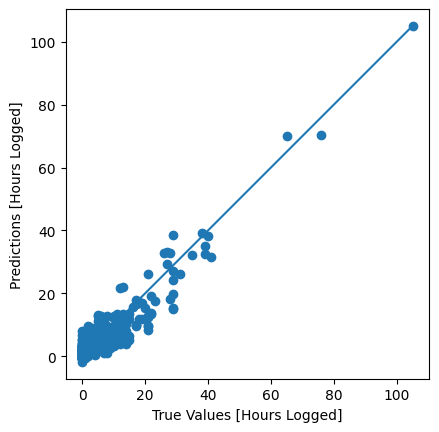

In [106]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
# calculate the limit
max_value = max(test_label.max(), test_predictions[0].max())
_ = plt.plot([0, max_value], [0, max_value]) 

Saving the predicted values as a csv file